## IQ Gateway Task
### Saquib Sattar
#### https://www.linkedin.com/in/saquib42/
#### 28novsaquib@gmail.com
#### Analysing the mood using classical Deep Learning Models

This notebook looks into using various Python-based deep learning and data science libraries in an attempt to build a model capable of predicting whether the emotion is sad, happy, angry or fear from text data.

We're going to take the following approach:
1. Problem definition
2. Data
3. Features
4. Evaluation
5. Modelling

## 1. Problem Definition

> Given text data from twitter, can we predict whether the emotion is sad, happy, angry or fear?

## 2. Data

> The data came from the WASSA-2017 Shared Task on Emotion Intensity (EmoInt Repository)

## 3. Features and Label

> Features are the raw text, score and we have corresponding label

## 4. Evaluation

> We will be evaluating our model based on these four accuracy measures: precision, recall, f1-score, support

## 5. Modelling

> Bi-directional LSTM is used

In [1]:
# importing all the important libraries
import pandas as pd
import numpy as np
import nltk
import re
import tensorflow as tf
from tensorflow.keras import regularizers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import string

In [2]:
Angry = pd.read_csv('Angry.txt', sep = '\t',names=['id', 'Tweet', 'Label', 'Score'])
Fear = pd.read_csv('Fear.txt', sep = '\t',names=['id', 'Tweet', 'Label', 'Score'])
Joy = pd.read_csv('Joy.txt', sep = '\t',names=['id', 'Tweet', 'Label', 'Score'])
Sad = pd.read_csv('Sad.txt', sep = '\t',names=['id', 'Tweet', 'Label', 'Score'])

### Combining all the text files

In [3]:
df = pd.concat([Angry, Fear, Joy, Sad], ignore_index=True)
df.head(3)

,id,Tweet,Label,Score
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896


In [4]:
len(Angry)+len(Fear)+len(Joy)+len(Sad) == len(df)

True

In [5]:
df['Label'] = df['Label'].map({'anger':1, 'fear':2, 'joy':3, 'sadness':4})

### Text Cleaning

In [6]:
# removes pattern in the input text
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, "", input_txt)
    return input_txt

In [7]:
df['Tweet'] = df['Tweet'].str.replace("[^a-zA-Z#]", " ")
df['Tweet'] = df['Tweet'].str.replace('((www\.[^\s]+)|(https?://[^\s]+))', " ")
df['Tweet'] = df['Tweet'].str.replace(r"\d+", " ")
df['Tweet'] = df['Tweet'].str.replace('&quot;', " ")
df['Tweet'] = df['Tweet'].str.replace(r"\b[a-zA-Z]\b", " ")
df['Tweet'] = df['Tweet'].str.replace("[^a-zA-Z#]", " ")
df['Tweet'] = df['Tweet'].str.replace(r"[^\w\s]", " ")
df['Tweet'] = df['Tweet'].str.replace(r'(.)\1+', " ")
df['Tweet'] = df['Tweet'].str.replace(r"\s+", " ")

df['Tweet'] = df['Tweet'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))

# stem the words
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
tokenized_tweet = df['Tweet'].apply(lambda x: x.split())
tokenized_tweet = tokenized_tweet.apply(lambda sentence: [stemmer.stem(word) for word in sentence])
# combine words into single sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = " ".join(tokenized_tweet[i])
df['Tweet'] = tokenized_tweet

df.head()

,id,Tweet,Label,Score
0,10000,heck move fridg should knock landlord angri,1,0.938
1,10001,indian uber driver just someon word wasn move ...,1,0.896
2,10002,ask parcel deliv pick store fume rcustomerservic,1,0.896
3,10003,whichev wipe fire alarm davi sound angri upset...,1,0.896
4,10004,join btcare they phone down talk over rude tak...,1,0.896


In [8]:
# Splitting the day into X and y
X = df['Tweet']
y = df['Label']

In [9]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X)
print(tokenizer.texts_to_sequences([X[3]]))

[[1319, 1320, 301, 177, 1769, 316, 72, 788, 302, 302, 789]]


In [10]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

In [11]:
padded_train_sequences = get_sequences(tokenizer, X)
padded_train_sequences[0]

array([1764,  208, 1765,   58,  903, 1766,   72,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [12]:
padded_train_sequences.shape

(3613, 50)

In [13]:
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(padded_train_sequences, y, test_size=0.15, 
                                                    random_state=42, shuffle=True, stratify=y)

In [14]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Model Training + Evaluation

In [25]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 512, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 512)           5120000   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 50, 40)            85280     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 246       
Total params: 5,215,286
Trainable params: 5,215,286
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Compile model
model2.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [27]:
history = model2.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/50
96/96 [==============================] - 13s 72ms/step - loss: 1.3998 - accuracy: 0.3722 - val_loss: 1.1094 - val_accuracy: 0.5387
Epoch 2/50
96/96 [==============================] - 5s 55ms/step - loss: 0.6514 - accuracy: 0.7906 - val_loss: 0.7044 - val_accuracy: 0.7583
Epoch 3/50
96/96 [==============================] - 5s 55ms/step - loss: 0.2289 - accuracy: 0.9365 - val_loss: 0.7117 - val_accuracy: 0.7638
Epoch 4/50
96/96 [==============================] - 5s 54ms/step - loss: 0.1218 - accuracy: 0.9678 - val_loss: 0.7582 - val_accuracy: 0.7786
Epoch 5/50
96/96 [==============================] - 5s 55ms/step - loss: 0.0839 - accuracy: 0.9782 - val_loss: 0.8445 - val_accuracy: 0.7546
Epoch 6/50
96/96 [==============================] - 5s 54ms/step - loss: 0.0668 - accuracy: 0.9798 - val_loss: 0.9071 - val_accuracy: 0.7472


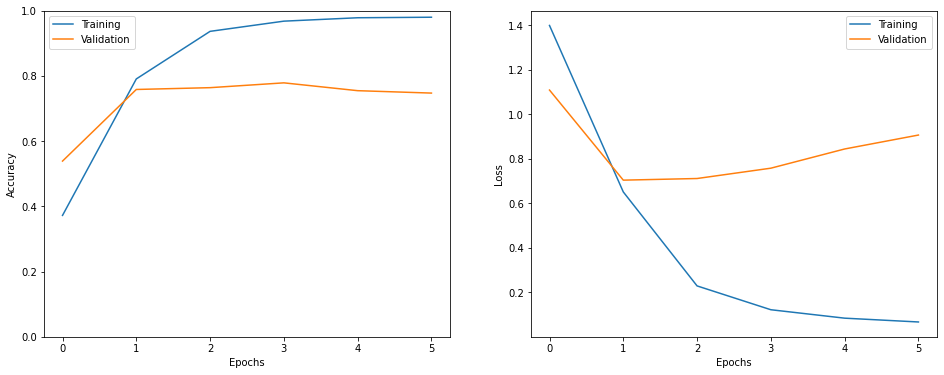

In [28]:
show_history(history)